# Calculation of the coverage area of fire hydrants in the Sedapal area (C.S. Callao)

## Importing libraries

In [1]:
#!pip install haversine
!pip install geopandas
!pip install folium
#!pip install geopy

     -------------------------------------- 102.3/102.3 kB 6.1 MB/s eta 0:00:00


In [3]:
# Import libraries
import os
#import haversine as hs
import geopandas as gpd
import pandas as pd
#from haversine import Unit
import numpy as np
import matplotlib.pyplot as plt
import math as m
import folium
#import fiona
#fiona.supported_drivers 
from shapely.ops import unary_union
from shapely import wkt
import shapely.geometry
import time
import seaborn as sns
from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree
from scipy.spatial.distance import cdist
from shapely.geometry import Point
#from geopy.distance import distance
from folium.plugins import MeasureControl
from folium.plugins import MarkerCluster

In [4]:
# Verifying python version
import sys
print(sys.version)

3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]


In [5]:
# Actual work directory
print(os.getcwd())

C:\Users\hmoreno\OneDrive - Superintendencia Nacional de Servicios de Saneamiento\TRABAJO\scripts\Calculo hidrantes


In [66]:
# List files inside actula directory
print(os.listdir())

['.gitignore', '.ipynb_checkpoints', 'Data', 'Distancias hidrantes.ipynb', 'img']


## Distances

### Calculate coordinates from UTM to geographic

In [7]:
# Reading files
shp_grifo = gpd.read_file("Data/GRIFO2023.shp")
shp_grifo = shp_grifo.to_crs(epsg=32718)
sectores = gpd.read_file("Data/Limite_de_Sectores.shp")
sectores = sectores.to_crs(epsg=32718)
sectores.to_file("Data/sectores_limite.geojson", driver="GeoJSON")
distritos = gpd.read_file("Data/provincia_lima_callao.shp")
distritos = distritos.to_crs(epsg=32718)

In [8]:
# Calculate areas for each polygon (sector)
sectores["AREA"] = sectores.area

In [9]:
# Spatial join (left) between 'shp_grifo' and 'sectores'
shp_grifo = shp_grifo.sjoin(sectores, how="left")
shp_grifo = shp_grifo.drop(["index_right"], axis=1)

In [10]:
# Spatial join (left) between 'shp_grifo' and 'distritos'
shp_grifo = shp_grifo.sjoin(distritos, how="left")
shp_grifo = shp_grifo.drop(["index_right"], axis=1)

In [11]:
# Delete District names from shp_grifo and sectores
shp_grifo = shp_grifo.drop(["DISTRITO_left"], axis=1)

In [12]:
# Verifying null rows
np.where(shp_grifo.DISTRITO_right.isnull())

(array([1874], dtype=int64),)

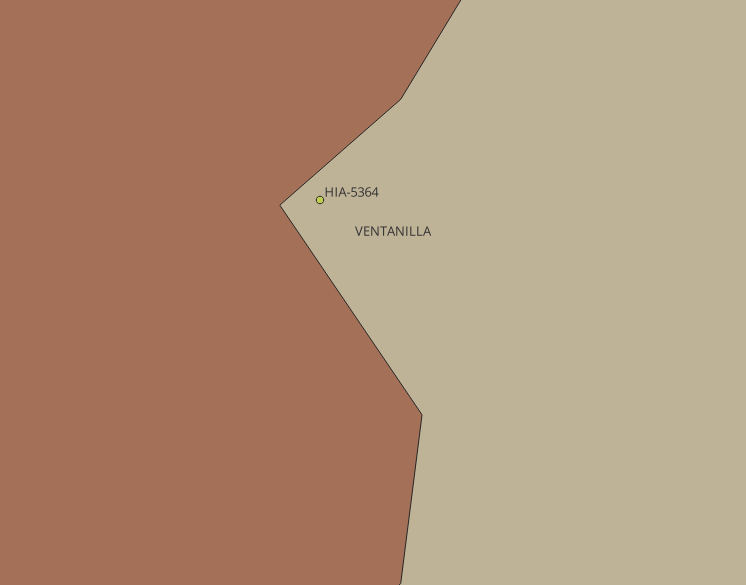

In [13]:
# Update row 1874 (HIA-5364) and 273 (SECTOR)
shp_grifo.loc[1874,"DISTRITO_right"] = "VENTANILLA"
shp_grifo.loc[1874,"SECTOR"] = 273

In [14]:
#Convert UTM to georaphic
shp_grifo = shp_grifo.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [15]:
shp_grifo = shp_grifo[~shp_grifo.geometry.is_empty]

# Extract "longitude" and "latitude" from "grometry" column
shp_grifo['longitude'] = shp_grifo.geometry.apply(lambda p: p.x)
shp_grifo['latitude'] = shp_grifo.geometry.apply(lambda p: p.y)
shp_grifo['coordenate'] = shp_grifo.geometry.apply(lambda p: (p.y,p.x)) #Tupla

In [16]:
# View first 5 rows
shp_grifo.head()

,FACILITYID,NIS,LOCDESC,DISTRICT,GESTOR,FACILITYNA,SUPPLYID_1,NIS_1,CALLE,NUMERO,...,UBIGEO,OBJECTID,NOMBDEP,NOMBPROV,NOMBDIST,CAPITAL,abastecido,longitude,latitude,coordenate
0,HIA-5340,5135548,"CA CASTILLA, MRCAL RAMON 412 ' ' ' ' - CERCADO",104,EOMR-CA,NaN,2009459,2009459,"CA CASTILLA, MRCAL RAMON",416,...,070104,1119.0,CALLAO,CALLAO,LA PERLA,LA PERLA,0,-77.121207,-12.067135,"(-12.06713455209079, -77.12120654554671)"
1,HIA-7275,2101132,"CA 13 0 F 09 - URB JAZMINES - III ET, LOS",101,EOMR-CA,NaN,2101133,2101133,CA 13,0,...,070101,1296.0,CALLAO,CALLAO,CALLAO,CALLAO,NO,-77.106079,-12.005080,"(-12.005080019658003, -77.10607866410133)"
2,HIA-1699,2000020,"AV HAYA DE LA TORRE, VICTOR RA 292 - COOP THO...",104,EOMR-CA,NaN,2000021,2000021,"AV HAYA DE LA TORRE, VICTOR RA",286,...,070104,1119.0,CALLAO,CALLAO,LA PERLA,LA PERLA,0,-77.108532,-12.067012,"(-12.067011592247008, -77.10853243210438)"
3,HIA-7413,2015848,"JR GUISSE, ALMTE MARTIN JORGE 120 - CERCADO",101,EOMR-CA,NaN,2039671,2039671,AV SAENZ PEÑA,496,...,070101,1296.0,CALLAO,CALLAO,CALLAO,CALLAO,NO,-77.141397,-12.060878,"(-12.060878305258072, -77.14139703708786)"
4,HIA-8010,2040025,"AV DOMINICOS, LOS 107 - URB VIPOL",101,EOMR-CA,NaN,2040025,2040025,"AV DOMINICOS, LOS",107,...,070101,1296.0,CALLAO,CALLAO,CALLAO,CALLAO,NO,-77.095606,-12.013239,"(-12.013238512908952, -77.09560551313814)"


### Distances


* Teoria:
https://www.wi.hs-wismar.de/~cleve/vorl/projects/dm/ss13/HierarClustern/Literatur/WittenFrank-DM-3rd.pdf

* Metric tree:https://en.wikipedia.org/wiki/Metric_tree

* Comparacion de los 3 algoritmos
https://towardsdatascience.com/tree-algorithms-explained-ball-tree-algorithm-vs-kd-tree-vs-brute-force-9746debcd940

https://varshasaini.in/kd-tree-and-ball-tree-knn-algorithm/

#### Ball Tree


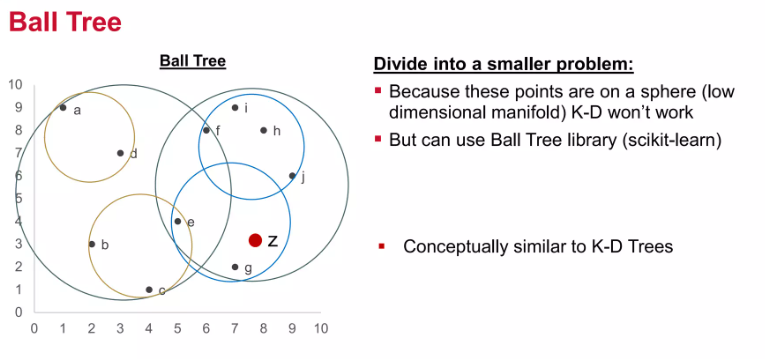

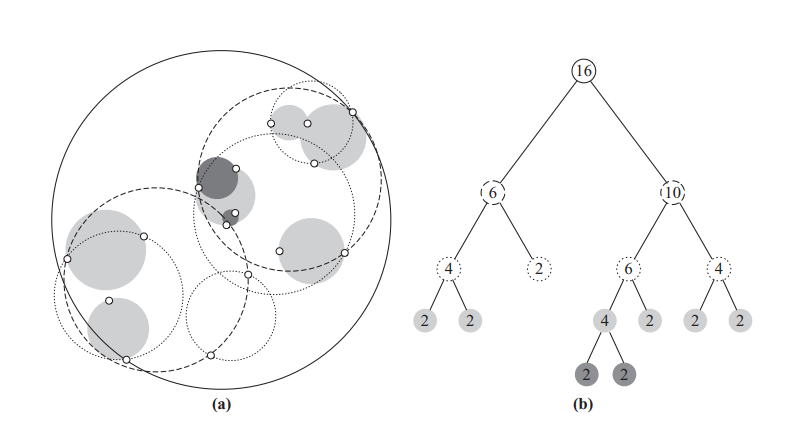

In [17]:
shp_grifo_cop = shp_grifo.copy()

In [18]:
#Codigo: https://towardsdatascience.com/using-scikit-learns-binary-trees-to-efficiently-find-latitude-and-longitude-neighbors-909979bd929b
for column in shp_grifo_cop[["latitude", "longitude"]]:
    rad = np.deg2rad(shp_grifo_cop[column].values)
    shp_grifo_cop[f'{column}_rad'] = rad

In [19]:
ball = BallTree(shp_grifo_cop[["latitude_rad", "longitude_rad"]].values, metric='haversine')
# The amount of neighbors to return.
k = 2
######################## DISTANCIA FINAL ############################
distances, indices = ball.query(shp_grifo_cop[["latitude_rad", "longitude_rad"]].values, k = k)
# CONVERSION A METROS DE LA TIERRA
# WGS-84 ellipsoid, Radius of Sphere of Equal Area (R2) = 6371007.1809
# REF: https://en.wikipedia.org/wiki/Earth_radius

In [20]:
distances, indices = ball.query(shp_grifo_cop[["latitude_rad", "longitude_rad"]].values, k = 2)

In [21]:
shp_grifo_cop["indices"] = [x[1] for x in indices.tolist()]
shp_grifo_cop["distances"] = [x[1] for x in distances.tolist()]

In [ ]:
#time1 = time.time()
#shp_grifo_cop["ID_PAR"] = [shp_grifo_cop.iloc[x]["FACILITYID"] for x in shp_grifo_cop.indices]
#time2 = time.time()
#time2-time1

0.9163727760314941

In [22]:
# Obtain the pair with minimum distance between two GCI
time1 = time.time()
shp_grifo_cop["ID_PAR_2"] = np.array(shp_grifo_cop.iloc[shp_grifo_cop.indices].FACILITYID)
time2 = time.time()
time2-time1

0.008015871047973633

In [ ]:
#time1 = time.time()
#shp_grifo_cop["distancia_metros"] = shp_grifo_cop["distances"]*6371007.1809
#time2 = time.time()
#time2-time1

In [23]:
# Copy results to a new column in the dataframe
time1 = time.time()
shp_grifo_cop["distancia_metros"] = np.array(shp_grifo_cop["distances"])*6371007.1809
time2 = time.time()
time2-time1

0.000993967056274414

In [24]:
shp_grifo_cop.tail()

,FACILITYID,NIS,LOCDESC,DISTRICT,GESTOR,FACILITYNA,SUPPLYID_1,NIS_1,CALLE,NUMERO,...,abastecido,longitude,latitude,coordenate,latitude_rad,longitude_rad,indices,distances,ID_PAR_2,distancia_metros
2166,HIA-6604,2085334,"AV CALDERON MEDRANO, MARCOS 0 W 09 - URB MO...",106,EOMR-CA,NaN,2085335,2094635,AV SANTA ROSA,0,...,NO,-77.121952,-11.889650,"(-11.889650196486027, -77.12195165381841)",-0.207514,-1.346032,1837,0.000011,HIA-6605,70.390805
2167,HIA-8747,2080928,JR TUMBES 0 F2 29/ AV MORALES DUARES - P.J ...,101,EOMR-CA,NaN,2080899,2087303,CA 29,0,...,NO,-77.122521,-12.039513,"(-12.039513011616643, -77.12252073149355)",-0.210129,-1.346042,1939,0.000019,HIA-8749,123.390023
2168,HIA-6465,2086168,"AV GONZALES GANOZA, JOSE 0 N 01 - URB MOREN...",106,EOMR-CA,NaN,2086148,2088384,CA 41,0,...,NO,-77.118939,-11.888659,"(-11.888659357892267, -77.11893917113645)",-0.207496,-1.345979,1900,0.000017,HIA-5360,107.886180
2169,HIA-1712,2082893,"AV MARINA, DE LA / CA TITICACA - URB DOIG LOS...",104,EOMR-CA,NaN,2082893,5107183,"ML PARDO, MANUEL",201,...,0,-77.116871,-12.067599,"(-12.067598700696962, -77.11687080556179)",-0.210619,-1.345943,1745,0.000012,HIA-1667,77.418010
2170,HIA-7217,2070090,"AV REPUBLICA DE ARGENTINA, 3644 - URB JULIO, 2",101,EOMR-CA,NaN,5819117,5081673,ML SAN MARTIN,585,...,NO,-77.106747,-12.049359,"(-12.04935942327974, -77.10674719433744)",-0.210301,-1.345767,1709,0.000027,HIA-7075,170.717319


In [27]:
shp_grifo_df = shp_grifo_cop.copy()

#### K-D Tree basic


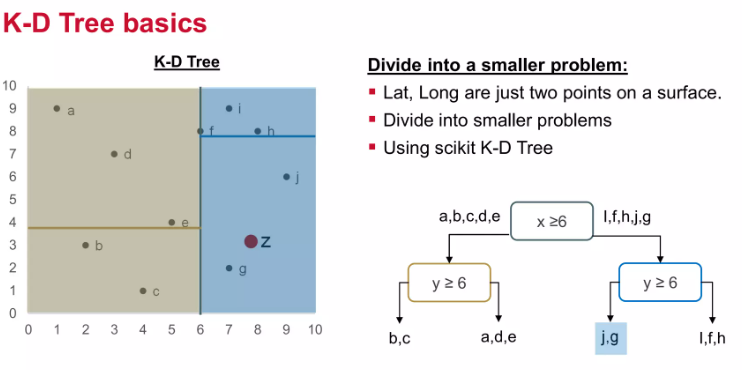

In [ ]:
def distancia_minima_radio(shapefile_path, radio, unidad_medida):

    # Extrae las coordenadas de los puntos como un arreglo NumPy
    puntos = np.array(shapefile_path.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())

    # Realiza la conversión de unidad de medida
    if unidad_medida == 'metros':
        radio = radio / 1000.0  # Convertir metros a kilómetros

    # Crea un árbol de búsqueda espacial (cKDTree) con las coordenadas de los puntos
    tree = cKDTree(np.radians(puntos))

    # Calcula las distancias mínimas dentro del radio para cada punto
    distancias_minimas = []
    for i in range(len(puntos)):
        indices = tree.query_ball_point(np.radians(puntos[i]), r=radio, return_sorted=False)
        if len(indices) > 1:
            distancias = tree.query(np.radians(puntos[i]), k=2)[0]
            distancias_minimas.append(distancias[1] if distancias[1] > 0 else 0)
        else:
            distancias_minimas.append(0)

    return distancias_minimas

In [ ]:
# Ejemplo de uso
shapefile_path = shp_grifo
radio = 300  # Radio en metros
unidad_medida = 'metros'
distancias_minimas = distancia_minima_radio(shapefile_path, radio, unidad_medida)
print("Distancias mínimas:", distancias_minimas)

Distancias mínimas: [1.395660607376882e-05, 2.5792972149809126e-05, 1.84511312269438e-05, 1.1793311316856241e-05, 1.2370497735198802e-05, 6.264796170282166e-06, 1.584936716068064e-05, 1.6634327201969594e-05, 3.2504754210676184e-05, 2.255798942591999e-05, 2.0665076525470174e-05, 1.754971029468215e-05, 2.0899099727433628e-05, 2.900486619043025e-05, 6.987655456977648e-06, 9.635366466673688e-06, 1.872166716033866e-05, 2.0441972312687073e-05, 1.2546683727345221e-05, 1.1102873753355599e-05, 1.4693587664125051e-05, 2.4266919357508634e-05, 1.8633459288681674e-05, 7.943636431188446e-06, 7.608178596672243e-06, 1.6666928970188927e-05, 1.6024952235611605e-05, 7.871705475441441e-06, 1.666035501854077e-05, 1.3972728943862055e-05, 2.066903201855089e-05, 2.5821300002791986e-05, 1.6885865924072326e-05, 1.960436863140717e-05, 3.952551682011793e-05, 2.5447675103551633e-05, 1.6941817508063e-06, 2.0114558122033233e-05, 1.3745052322301554e-05, 1.5763114934505606e-05, 1.939097323924142e-05, 3.949126031434332

<img src="img/grifos.png" width="200" height="200" alt="MDN">

#### Brute Force Algorithms

In [26]:
shp_grifo_df = shp_grifo.to_wkt()

In [ ]:
# Generate matrix of zeros
distances = np.zeros((shp_grifo_df.shape[0], shp_grifo_df.shape[0]))

# Initialize an empty array
distances_aux = []
new_list = []

In [ ]:
# Calculate distances from one GCI to all the points
for i in range(len(shp_grifo_df)):
    for j in range(len(shp_grifo_df)):
        distances[i][j] = hs.haversine(shp_grifo_df["coordenate"][i], shp_grifo_df["coordenate"][j], unit=Unit.METERS)
    distances_aux.append(np.min(distances[i][np.nonzero(distances[i])]))
    # Identify the code where the minimum distance is iqual to the distances vector 
    new_list.append(shp_grifo_df.iloc[np.where(distances[i]==distances_aux[i])[0][0]].FACILITYID)

### Descriptive Statistic

In [28]:
# Generate a new variable
shp_grifo_df["estado"] = np.where(shp_grifo_df.distancia_metros > 300, "No cumple", "Si cumple")
grifos_distances = shp_grifo_df.loc[shp_grifo_df["estado"]=="No cumple", ["distancia_metros","ID_PAR_2","FACILITYID","SECTOR","NOMBDIST"]]
# Rename columns
grifos_distances = grifos_distances.rename(columns={
    "distancia_metros":"DISTANCE","ID_PAR_2":"FACILITYID_MIN","NOMBDIST":"DISTRITO"
}).sort_values(by="DISTANCE")
# Reorder columns
new_order= ["DISTRITO","SECTOR","FACILITYID","FACILITYID_MIN","DISTANCE"]
grifos_distances = grifos_distances.reindex(columns=new_order)
grifos_distances

,DISTRITO,SECTOR,FACILITYID,FACILITYID_MIN,DISTANCE
1369,VENTANILLA,276.0,HIA-6074,HIA-5752,304.661718
467,SANTA ROSA,216.0,HIA-22319,HIA-22318,308.160840
2019,SAN MARTIN DE PORRES,252.0,HIA-12696,HIA-6227,308.910484
1618,ANCON,215.0,HIA-6970,HIA-6973,312.053106
1800,CALLAO,121.0,HIA-24691,HIA-6239,312.483101
238,SANTA ROSA,214.0,HIA-6968,HIA-6958,314.621047
296,SAN MARTIN DE PORRES,254.0,HIA-20492,HIA-20468,334.310646
45,CALLAO,257.0,HIA-6031,HIA-6032,334.725378
683,CARMEN DE LA LEGUA REYNOSO,100.0,HIA-2495,HIA-6357,341.528831
1151,CALLAO,108.0,HIA-8892,HIA-20165,356.802490


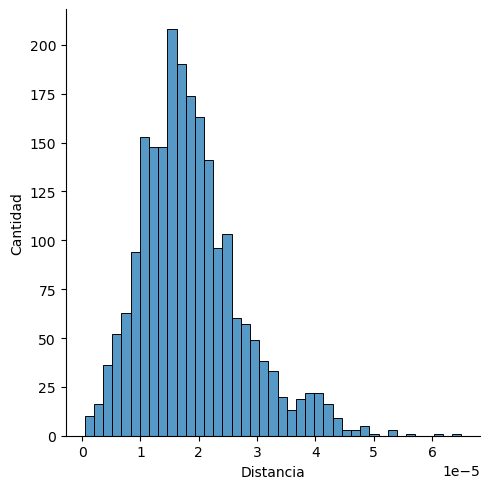

In [30]:
# Histogram distances
sns.displot(shp_grifo_df.distances)
plt.xlabel('Distancia')
plt.ylabel('Cantidad')
plt.savefig("img/h_1.png")

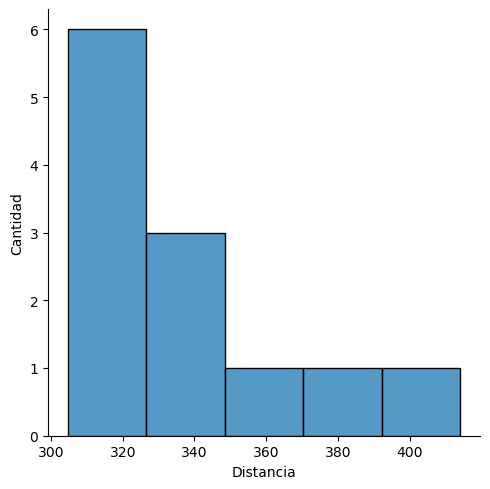

In [31]:
# Histogram distances > 300
sns.displot(grifos_distances.DISTANCE)
plt.xlabel('Distancia')
plt.ylabel('Cantidad')
plt.savefig("img/h_2.png")

In [33]:
# Rename columns
shp_grifo_df.rename(columns={
    "FACILITYID":"ID",
    "ID_PAR_2":"ID_MIN",
    "DISTRITO_right":"DISTRITO",
    "distancia_metros":"DISTANCE"
}, inplace=True)

shp_grifo_df = shp_grifo_df[["DISTRITO","SECTOR","ID","ID_MIN","DISTANCE","AREA","geometry","latitude","longitude"]]

In [34]:
shp_grifo_df.head()

,DISTRITO,SECTOR,ID,ID_MIN,DISTANCE,AREA,geometry,latitude,longitude
0,BELLAVISTA,107.0,HIA-5340,HIA-5339,88.286300,2.174130e+06,POINT (-77.12121 -12.06713),-12.067135,-77.121207
1,CALLAO,116.0,HIA-7275,HIA-7276,162.554851,1.803629e+06,POINT (-77.10608 -12.00508),-12.005080,-77.106079
2,LA PERLA,105.0,HIA-1699,HIA-1086,116.108984,3.395514e+06,POINT (-77.10853 -12.06701),-12.067012,-77.108532
3,CALLAO,109.0,HIA-7413,HIA-7398,75.127478,2.528528e+06,POINT (-77.14140 -12.06088),-12.060878,-77.141397
4,CALLAO,116.0,HIA-8010,HIA-8051,77.214035,1.803629e+06,POINT (-77.09561 -12.01324),-12.013239,-77.095606


<img src="img/sectores-grifo.png" width="200" height="200" alt="MDN">

### Export Shapefile

In [ ]:
# Create a geoserie from a list or array of WKT objects and save in a new column "Coordinate_aux"
#shp_grifo_df['geometry'] = gpd.GeoSeries.from_wkt(shp_grifo_df['geometry'])

In [ ]:
#shp_grifo_mod = gpd.GeoDataFrame(shp_grifo_df, geometry='geometry', crs="EPSG:32718") # Peru 18S

In [35]:
# Export shapefile
shp_grifo_df.to_file('Data/shp_grifo_df.shp',index=True)

### Map

In [ ]:
# Location
map = folium.Map(location=[shp_grifo_df.latitude.mean(), shp_grifo_df.longitude.mean()], zoom_start=11, control_scale=True)
for i, row in shp_grifo_df.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], color="green", radius=0.5).add_to(map)
#map

In [ ]:
# Location categorized by distance
map = folium.Map(location=[shp_grifo_df.latitude.mean(), shp_grifo_df.longitude.mean()], zoom_start=11, control_scale=True)
for i, row in shp_grifo_df.iterrows():
    color = 'green' if row['DISTANCE'] <= 300 else "red"
    folium.CircleMarker(location=[row['latitude'], row['longitude']], color=color, fill_color=color, radius=0.5).add_to(map)

# Create a list of coordinate pairs
locations = list(zip(shp_grifo_df["latitude"], shp_grifo_df["longitude"]))
marker_cluster = MarkerCluster(locations)
# Add marker cluster to map
marker_cluster.add_to(map)

map.add_child(MeasureControl())
#map

## Buffer

In [36]:
# Read dhapefile
shp_grifo = gpd.read_file("Data/shp_grifo_df.shp")

# Projection
shp_grifo = shp_grifo.to_crs(epsg=32718)

# Generate a buffer around the point (r = 300m)
shp_grifo["shp_grifo_buffer"] = shp_grifo.geometry.buffer(300)

In [37]:
# Absolute frequency table
table_district = shp_grifo.dissolve(by='DISTRITO', aggfunc={"ID":"count"})

table_district.reset_index(inplace=True)

table_district.rename(columns={
    "ID":"CANTIDAD"
}, inplace=True)

table_district = table_district[["DISTRITO","CANTIDAD"]]
table_district

,DISTRITO,CANTIDAD
0,ANCON,85
1,BELLAVISTA,163
2,CALLAO,974
3,CARMEN DE LA LEGUA,29
4,LA PERLA,150
5,LIMA,4
6,LOS OLIVOS,1
7,PUENTE PIEDRA,5
8,SAN MARTIN DE PORRES,22
9,SANTA ROSA,85


In [38]:
shp_grifo_mod = shp_grifo[["SECTOR","AREA"]].drop_duplicates()

In [39]:
AreaSecTotal = shp_grifo_mod.AREA.sum()

In [40]:
# Calculate area (km2) for each sector
AreaSecTotal_km2 = AreaSecTotal / 10e6

In [41]:
AreaSecTotal_km2

14.365581575085598

In [42]:
polys1 = []
for i in range(len(shp_grifo)):
    polys1.append(shp_grifo["shp_grifo_buffer"][i])

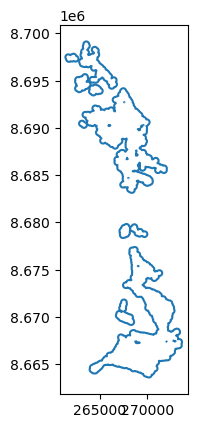

In [43]:
mergedPolys = unary_union(polys1)

gpd.GeoSeries([mergedPolys]).boundary.plot()
plt.show()

<img src="img/buffer_v2.png" width="400" height="400" alt="MDN">

In [44]:
# Convert to geodataframe
grifos_buffer300 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(mergedPolys))

In [45]:
# Project geotadaframe to crs=32718 (18S)
grifos_buffer300_mod = gpd.GeoDataFrame(grifos_buffer300, geometry='geometry', crs="EPSG:32718")

In [46]:
# Export to shapefile
grifos_buffer300_mod.to_file('Data/grifos_buffer300.shp')

In [47]:
# Area in km2
# .area -> in m2
AreaHidrantes_Km2 = mergedPolys.area /10e6

In [48]:
# Area not-adjusted
(AreaHidrantes_Km2 / AreaSecTotal_km2)*100

71.09371874008268

## Sectors - Fire Hydrant

In this section, I will adjust the polygon

In [49]:
sectores_unicos = shp_grifo.SECTOR.unique().tolist()
sectores_grifo = sectores[sectores.SECTOR.isin(sectores_unicos)]

<Axes: >

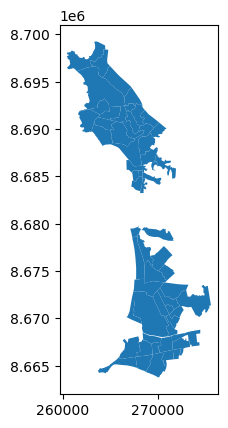

In [50]:
sectores_grifo.plot()

### Export shapefile

In [51]:
sectores_grifo_mod = gpd.GeoDataFrame(sectores_grifo, geometry='geometry', crs="EPSG:32718")
# Export shapefile
sectores_grifo_mod.to_file('Data/sectores_grifo_df.shp')
sectores_grifo_mod.to_file("Data/sectores_grifo_mod.geojson", driver="GeoJSON")

In [54]:
sectores = gpd.read_file('Data/sectores_grifo_df.shp')
sectores = sectores.to_crs(epsg=32718)
grifos = gpd.read_file('Data/shp_grifo_df.shp')

In [55]:
sectores = gpd.read_file("Data/Limite_de_Sectores.shp")
sectores = sectores.to_crs(epsg=32718)
distritos = gpd.read_file("Data/provincia_lima_callao.shp")
distritos = distritos.to_crs(epsg=32718)

## Diference between buffer-grifos and unique sectors

In [56]:
grifos_buffer300_dif = gpd.read_file("Data/grifos_buffer300.shp")
sectores_grifo_df_dif = gpd.read_file("Data/sectores_grifo_df.shp")

In [57]:
dif_buffer_sector = grifos_buffer300_dif.overlay(sectores_grifo_df_dif, how='difference')

C:\Users\hmoreno\AppData\Local\anaconda3\lib\site-packages\geopandas\geodataframe.py:2452: UserWarning: `keep_geom_type=True` in overlay resulted in 54 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


<img src="img/diff-buffer_v2.png" width="400" height="400" alt="MDN">

<Axes: >

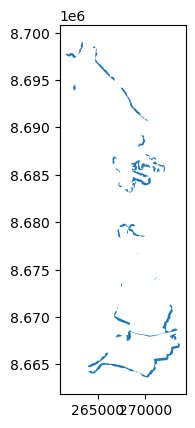

In [58]:
dif_buffer_sector.plot()

In [59]:
dif_buffer_sector.to_file('Data/dif_buffer_sector.shp')

In [60]:
buffer_sector_final = grifos_buffer300_dif.overlay(dif_buffer_sector, how='difference')

In [61]:
buffer_sector_final.to_file('Data/buffer_sector_final.shp')

<Axes: >

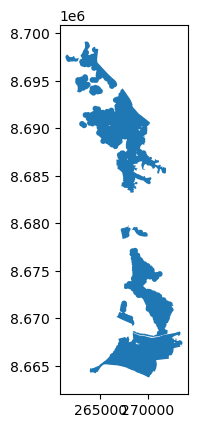

In [62]:
buffer_sector_final.plot()

<img src="img/mapafinal.png" width="400" height="400" alt="MDN">

In [63]:
AreaHidrantesDiff_Km2 = dif_buffer_sector.area[0] /10e6

In [64]:
# Adjusted Area (km2)
AreahHidranteFinal = AreaHidrantes_Km2 - AreaHidrantesDiff_Km2

In [65]:
# Adjusted Area (%)
AreaFinal = (AreahHidranteFinal / AreaSecTotal_km2) * 100
AreaFinal

63.10082446582249